# Predicting Professor Evals

This notebook analyzes professor ratings and reviews, merges it with gender info from SSA and builds regression models to predict professor ratings. 

download babynames from
https://www.ssa.gov/oact/babynames/ 
scape files, get year, probability for male/female, can also guage age with this

In [5]:
from __future__ import print_function, division

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import re
import time
import random

%matplotlib inline


### Data Cleaning & Feature Engineering

In [1374]:
df = pd.read_csv('10-26_RP.csv')

In [ ]:
#getting gender from SSA names database 
import glob

allFiles = glob.glob('names/*.txt')
names =  pd.concat([pd.read_csv(f, index_col=0, header=None) for f in allFiles], keys=allFiles)
names.columns = ['Name', 'Gender', 'Num']

In [1252]:
df = df.merge(names, on = 'Name' )

In [1253]:
# Tags was turned into a string. Need to convert to an actual list
df.Tags[0][:3]

'[]'

In [1325]:
from ast import literal_eval
from scipy.stats import sem

In [1376]:
# get standard error of the mean for DV ("Overall Quality")
df['Overall_Qual_scores'] = df.Overall_Qual_scores.apply(lambda x: [float(i) for i in literal_eval(x)])
df['OQ_SEM'] = df.Overall_Qual_scores.apply(lambda x: sem(x))

/Users/kellygola/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


In [1377]:
df['Tags'] = df.Tags.apply(lambda x: literal_eval(x))

In [1378]:
#expand tags list into separate columns 
tags = df['Tags'].apply(pd.Series).stack().str.extract(r'(\w+).*\((\d+)', expand=True)\
              .reset_index(1, drop=True)\
              .set_index(0, append=True)[1]\
              .unstack(1)
tags.shape

(6507, 20)

In [1379]:
tags.columns = ['Tag_' + str(i) for i in np.arange(20)]

In [1381]:
tags.fillna(0)
tags = tags.apply(pd.to_numeric, errors='ignore')

In [1331]:
tags['TotalFeedback'] = tags.sum(axis=1)

In [1382]:
df = pd.concat([df,tags], axis = 1)

In [1393]:
# df.drop(['ACCESSIBLE','Amazing','BEWARE','Caring','Clear','EXTRA','GRADED',
#                'GROUP','Get','Gives','Hilarious', 'Inspirational','LECTURE','LOTS','Participation',
#                     'Respected', 'SO', 'Skip', 'TEST','Tough'], axis=1, inplace=True)

In [670]:
df = pd.read_csv('10-26_RMP.csv')

In [1384]:
df['State'] = df['State'].replace('Pomona', 'CA')
df['State'] = df['State'].replace('Northridge', 'CA')
df['State'] = df['State'].replace('Sacramento', 'CA')
df['State'] = df['State'].replace('Mankato','MN')
df['State'] = df['State'].replace('Baltimore','MD')
df['State'] = df['State'].replace('Camrose','AB')

In [1385]:
#create Region variable based on US Census Data 

NE1 = ['CT','ME', 'MA', 'NH', 'RI', 'VT']
NE2 = ['NJ', 'NY', 'PA']
MW1 = ['IL', 'IN', 'MI', 'OH', 'WI']
MW2 = ['IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD']
S1 = ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV']
S2 = ['AL', 'KY', 'MS', 'TN']
S3 = ['AR', 'LA', 'OK', 'TX']
W1 = ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY']
W2 = ['AK', 'CA', 'HI', 'OR', 'WA']
Can = ['AB', 'QC', 'ON', 'BC', 'SK', 'MB', 'NB']

df['Northeast1'] = np.where(df["State"].isin(NE1), 1, 0)
df['Northeast2'] = np.where(df["State"].isin(NE2), 1, 0)
df['Midwest1'] = np.where(df["State"].isin(MW1), 1, 0)
df['Midwest2'] = np.where(df["State"].isin(MW2), 1, 0)
df['South1'] = np.where(df["State"].isin(S1), 1, 0)
df['South2'] = np.where(df["State"].isin(S2), 1, 0)
df['South3'] = np.where(df["State"].isin(S3), 1, 0)
df['West1'] = np.where(df["State"].isin(W1), 1, 0)
df['West2'] = np.where(df["State"].isin(W2), 1, 0)
df['Canada'] = np.where(df["State"].isin(Can), 1, 0)


In [1386]:
def label_region(row):
    """Creates single variable of US and Canadian regions"""
    if row['Northeast1'] == 1 :
        return 'Northeast1'
    if row['Northeast2'] == 1 :
        return 'Northeast2'
    if row['Midwest1'] == 1:
        return 'Midwest1'
    if row['Midwest2']  == 1:
        return 'Midwest2'
    if row['South1'] == 1:
        return 'South1'
    if row['South2'] == 1:
        return 'South2'
    if row['South3'] == 1:
        return 'South3'
    if row['West1'] == 1:
        return 'West1'
    if row['West2'] == 1:
        return 'West2'
    if row['Canada'] == 1:
        return 'Canada'

In [1387]:
# create discipline variables according to the subsect 

art = ['Architecture','Art','Art&ArtHistory','Art&Design','ArtHistory','ArtStudio','Arts&Humanities','CulinaryArts',
       'Dance','Design','DramaticArts','Fashion','FineArts','GraphicArts','GraphicDesign','HistoryInArt',
       'IndustrialDesign','Music','MusicHistory',
       'Theater','Theatre&Dance','Theatre&MediaArts','Visual&PerformingArts','VisualArts']

biology = ['AlliedHealth','Anatomy','Anatomy&Physiology','AnimalScience','Biochemistry',
           'Bioengineering','BiologicalSciences','Biology','Biomaterials&BiomedicalEngineering',
           'Biomedical','Chemistry','Ecology&EvolutionaryBiology', 'Entomology','Exercise&SportScience',
           'ExerciseScience&Health','Food&Nutrition','Genetics','FoodScience','HealthScience','HumanKinetics',
           'Kinesiology','MacRomolecularScience&Eng','Medicine','Microbiology','Neuroscience','Nursing',
           'Nutrition','Pharmacology', 'PhysicalEd','PhysicalEducation',
           'PhysicianAssistantStudies','Physiology', 'VeterinarySciences','Zoology']
          
business = ['Accountancy','Accounting''Business','Business&Info.Technology','BusinessAdministration',
            'BusinessLaw','CareerOrientation','CooperativeWorkExperience', 'Hospitality&Tourism','Family&ConsumerScience',
            'Finance','Finance&BusinessLaw','GeneralBusiness','HumanServices','Leadership','Management','ManagerialScience',
            'Manufacturing&Construction','Marketing','Marketing&ComputerInformationSystems','MusicBusiness',
            'RealEstate','SupplyChainManagement','TechnologyManagement','NonprofitManagement','TourismStudies', 
            'TravelIndustry','Labor&EmploymentRelations']

CS = ['AdvTechnology','Computer&InformationalTech.','ComputerEngineering','ComputerGraphics',
      'ComputerInformationSystems','ComputerScience','Informatics','InformationDecisionSciences',
      'InformationScience','InformationSystems','InformationTechnology','SoftwareEngineering','SystemsEngineering']

education = ['AdultBasicEducation', 'ArtEducation','CommunityHealthEducation', 
             'EarlyChildhoodEducation','IntellectualHeritage','Education',
             'MusicEducation','Reading', 'SecondaryEducation','SpecialEducation', 'LibraryScience']

ethnic = ['African-AmericanStudies','AsianStudies','CulturalStudies','EthnicStudies','ForeignLanguages&Literature',
          'HispanicStudies','NativeStudies','NearEasternStudies',  'NotSpecified','Pacific&AsianStudies',
          'WorldLanguages&Cultures']

lang = ['Chinese','Classics','EnGlish','English','French','German','Italian','Japanese','Languages','ModernLanguages',
        'SignLanguage', 'Spanish']

law_ps = ['AdministrationOfJustice','CriminalJustice','Criminology','Criminology&CriminalJustice','GlobalStudies',
          'Government','Govt&InternationalRelations', 'ForensicStudies', 'History&PoliticalScience',
         'InternationalRelations','InternationalStudies','Law','LegalStudies','Peace&ConflictStudies',
          'PoliticalScience','History','Philosophy','EmergencyManagement', 'LossPrevention&Safety','Planning','PublicAdministration']

math = ['AppliedMathematics','Economics','Mathematics','Statistics']

media = ['AcademyforCreativeMedia','Communication','CommunicationSciences','CommunicationStudies','Communications','Film','Film&Video',
         'Journalism','Journalism&MediaStudies','MediaArts','MediaStudies','MassCommunications','Multimedia',
         'NewMediaArt','PublicSpeaking','Radio,TV&Film','TV&Radio']


natural_sci = ['Agriculture','Earth&EnvironmentalSciences', 'EarthScience', 'EnvironmentalResources',
               'EnvironmentalScience','EnvironmentalStudies','GeologicalEngineering','Geology','MaterialsScience',
               'NaturalResources','NaturalScience','NaturalSciences','FireScience','Forestry', 'Geography']

physics_engineer = [ 'AerospaceEngineering','AerospaceStudies','Astronomy','AutomotiveTechnology',
                    'Aviation', 'ChemicalEngineering','CivilEngineering','Electrical&Comp.Engineering',
                    'ElectricalEngineering','Engineering','EngineeringTechnology', 'MechanicalEngineering',
                    'Meteorology','MiningEngineering','NuclearEngineering','Petroleum','Physics','Physics&Astronomy',
                    'Physics&Chemistry','Science']
             
theology = ['Bible,Missions&Ministry','BiblicalStudies','Philosophy&Religion','Religion','ReligiousStudies',
            'Theology','YouthMinistry'] 

psychology_behsci = ['AppliedHumanSciences','AppliedLinguistics&DiscourseStudies', 'Anthropology','BehavioralSciences',
                     'ChildDevelopment', 'CommunicationDisorders','DecisionScience', 'EarTraining',
                     'Family&ChildSciences','FamilyStudies','HumanDevelopment',  'Humanities,Social&BehavSci',    
                     'Linguistics','MovementSciences','Psychology','SocialScience','SocialWork','Sociology',
                     'Speech&HearingSciences','SpeechCommunication','SpeechPathology&Audiology',
                     'GenderStudies','Women',"Women'sStudies",'Womens&GenderStudies']

literature = ['ComparativeLiterature','English&LiberalStudies','EnglishLanguage&Literature',
              'Folklore','History&Classics','Humanities','Languages&Literature','Literature','ModernLanguages&Literature',
              'ModernLanguages&Literatures','Writing''LiberalArts&Sciences','LiberalStudies']


other = ['Honors','FreshmanSeminar','LearningCenter','ProfessionalPrograms','Recreation','AcademicServices']
     
 
    

In [1388]:
df['Art'] = np.where(df["Subject"].isin(art), 1, 0)
df['Biology'] = np.where(df["Subject"].isin(biology), 1, 0)
df['Business'] = np.where(df["Subject"].isin(business), 1, 0)
df['CS'] = np.where(df["Subject"].isin(CS), 1, 0)
df['Education'] = np.where(df["Subject"].isin(education), 1, 0)
df['EthnicStud'] = np.where(df["Subject"].isin(ethnic), 1, 0)
df['Languages'] = np.where(df["Subject"].isin(lang), 1, 0)
df['Law_PolySci'] = np.where(df["Subject"].isin(law_ps), 1, 0)
df['Literature'] = np.where(df["Subject"].isin(literature), 1, 0)
df['Math'] = np.where(df["Subject"].isin(math), 1, 0)
df['Media'] = np.where(df["Subject"].isin(media), 1, 0)
df['NaturalSci'] = np.where(df["Subject"].isin(natural_sci), 1, 0)
df['Physics_Eng'] = np.where(df["Subject"].isin(physics_engineer), 1, 0)
df['Psych_Behav'] = np.where(df["Subject"].isin(psychology_behsci), 1, 0)
df['Theology'] = np.where(df["Subject"].isin(theology), 1, 0)
df['Other'] = np.where(df["Subject"].isin(other), 1, 0)



In [1389]:
#Create regions variable to test distributions
def label_dept(row):
    """Creates single variable of US and Canadian regions"""
    if row['Art'] == 1 :
        return 'Art'
    if row['Biology'] == 1 :
        return 'Biology'
    if row['Business'] == 1:
        return 'Business'
    if row['CS']  == 1:
        return 'CS'
    if row['Education'] == 1:
        return 'Education'
    if row['EthnicStud'] == 1:
        return 'EthnicStud'
    if row['Languages'] == 1:
        return 'Languages'
    if row['Law_PolySci'] == 1:
        return 'Law_PolySci'
    if row['Literature'] == 1:
        return 'Literature'
    if row['Math'] == 1:
        return 'Math'
    if row['Media'] == 1:
        return 'Media'
    if row['NaturalSci'] == 1:
        return 'NaturalSci'
    if row['Physics_Eng'] == 1:
        return 'Physics_Eng'
    if row['Psych_Behav'] == 1:
        return 'Psych_Behav'
    if row['Theology'] == 1:
        return 'Theology'
    if row['Other'] == 1:
        return 'Other'

In [1390]:
df['region_label'] = df.apply(lambda row: label_region(row),axis=1)
df['region_label'][0:5]

0       West2
1    Midwest1
2      Canada
3       West2
4       West2
Name: region_label, dtype: object

In [1391]:
df['dept_label'] = df.apply(lambda row: label_dept(row),axis=1)
df['dept_label'][0:5]

0          Media
1    Psych_Behav
2           Math
3    Law_PolySci
4          Media
Name: dept_label, dtype: object

In [1394]:
df.apply(pd.to_numeric, errors='ignore').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13504 entries, 0 to 13503
Data columns (total 65 columns):
Name                   13504 non-null object
Gender                 13504 non-null object
Comments               13504 non-null object
Overall_Qual_scores    13504 non-null object
ProfID                 13504 non-null int64
Subject                13504 non-null object
City                   13504 non-null object
Difficulty             13504 non-null float64
Grade_Received         8200 non-null float64
Hot                    13504 non-null object
Num_Ratings            13504 non-null int64
Overall_Quality        13504 non-null float64
School                 13504 non-null object
State                  13504 non-null object
Tags                   13504 non-null object
TotalFeedback          6507 non-null float64
OQ_SEM                 12721 non-null float64
Tag_0                  1175 non-null float64
Tag_1                  2412 non-null float64
Tag_2                  676 non-null

** Data Manipulation & Feature Engineering**

In [1279]:
df.columns

Index(['Name', 'Gender', 'Comments', 'Overall_Qual_scores', 'ProfID',
       'Subject', 'City', 'Difficulty', 'Grade_Received', 'Hot', 'Num_Ratings',
       'Overall_Quality', 'School', 'State', 'Tags', 'TotalFeedback', 'OQ_SEM',
       'Tag_0', 'Tag_1', 'Tag_2', 'Tag_3', 'Tag_4', 'Tag_5', 'Tag_6', 'Tag_7',
       'Tag_8', 'Tag_9', 'Tag_10', 'Tag_11', 'Tag_12', 'Tag_13', 'Tag_14',
       'Tag_15', 'Tag_16', 'Tag_17', 'Tag_18', 'Tag_19', 'TotalFeedback',
       'Northeast1', 'Northeast2', 'Midwest1', 'Midwest2', 'South1', 'South2',
       'South3', 'West1', 'West2', 'Canada', 'Art', 'Biology', 'Business',
       'CS', 'Education', 'EthnicStud', 'Languages', 'Law_PolySci',
       'Literature', 'Math', 'Media', 'NaturalSci', 'Physics_Eng',
       'Psych_Behav', 'Theology', 'Other', 'region_label', 'dept_label'],
      dtype='object')

In [681]:
#State Averages as a proxy for location
#df1=df.join(df.groupby('State')['Overall_Quality'].mean(), on='State', rsuffix='_State_Avg')

In [1395]:
raw = df[['Tag_0', 'Tag_1', 'Tag_2', 'Tag_3', 'Tag_4', 'Tag_5', 'Tag_6', 'Tag_7',
       'Tag_8', 'Tag_9', 'Tag_10', 'Tag_11', 'Tag_12', 'Tag_13', 'Tag_14',
       'Tag_15', 'Tag_16', 'Tag_17', 'Tag_18', 'Tag_19','Num_Ratings','TotalFeedback']]


In [1396]:
print(raw.isnull().sum())

Tag_0            12329
Tag_1            11092
Tag_2            12828
Tag_3            10674
Tag_4            11138
Tag_5            12427
Tag_6            12488
Tag_7            12769
Tag_8            10487
Tag_9            10361
Tag_10           11166
Tag_11           11217
Tag_12           10861
Tag_13           11329
Tag_14           11003
Tag_15           10329
Tag_16           12678
Tag_17           10161
Tag_18           12498
Tag_19            9636
Num_Ratings          0
TotalFeedback     6997
dtype: int64


In [1397]:
raw = raw.fillna(0)

In [1398]:
raw.apply(pd.to_numeric, errors='ignore').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13504 entries, 0 to 13503
Data columns (total 22 columns):
Tag_0            13504 non-null float64
Tag_1            13504 non-null float64
Tag_2            13504 non-null float64
Tag_3            13504 non-null float64
Tag_4            13504 non-null float64
Tag_5            13504 non-null float64
Tag_6            13504 non-null float64
Tag_7            13504 non-null float64
Tag_8            13504 non-null float64
Tag_9            13504 non-null float64
Tag_10           13504 non-null float64
Tag_11           13504 non-null float64
Tag_12           13504 non-null float64
Tag_13           13504 non-null float64
Tag_14           13504 non-null float64
Tag_15           13504 non-null float64
Tag_16           13504 non-null float64
Tag_17           13504 non-null float64
Tag_18           13504 non-null float64
Tag_19           13504 non-null float64
Num_Ratings      13504 non-null int64
TotalFeedback    13504 non-null float64
dtypes: float

In [1399]:
raw.Num_Ratings = raw1.Num_Ratings.astype(float)

In [1400]:
def get_rating_averages(data):
    """calculates (tag / number of ratings) average for each column in
        dataframe, returns new dataframe with averages only"""
    for name in data.columns.tolist():
        if name != 'Num_Ratings':
            data['{}_avg'.format(name)] = data[name] / data.Num_Ratings
            data = data.drop(name, 1)
    return data

In [1401]:
df1 = get_rating_averages(raw)

In [1402]:
df1.head()

,Num_Ratings,Tag_0_avg,Tag_1_avg,Tag_2_avg,Tag_3_avg,Tag_4_avg,Tag_5_avg,Tag_6_avg,Tag_7_avg,Tag_8_avg,...,Tag_11_avg,Tag_12_avg,Tag_13_avg,Tag_14_avg,Tag_15_avg,Tag_16_avg,Tag_17_avg,Tag_18_avg,Tag_19_avg,TotalFeedback_avg
0,50.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,99.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2,169.0,0.0,0.04142,0.0,0.017751,0.017751,0.0,0.0,0.0,0.0,...,0.005917,0.0,0.017751,0.0,0.059172,0.0,0.047337,0.0,0.017751,0.301775
3,88.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,51.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [1403]:
df2 = pd.merge(df1, df, how='outer', on = None, right_index = True, left_index = True)

In [1404]:
# dummy codes 'Hot' and adds it to dataframe
df_hot = pd.get_dummies(df2['Hot'])
df_state = pd.get_dummies(df2['State'])
df_sex = pd.get_dummies(df2['Gender'])
df_subject = pd.get_dummies(df2['Subject'])

In [1405]:
df2 = pd.merge(df2, df_hot, how='outer', on = None, right_index = True, left_index = True)
df2= pd.merge(df2, df_state, how='outer', on = None, right_index = True, left_index = True)
df2 = pd.merge(df2, df_sex, how='outer', on = None, right_index = True, left_index = True)
df2 = pd.merge(df2, df_subject, how='outer', on = None, right_index = True, left_index = True)

In [1406]:
df2.head()

,Num_Ratings_x,Tag_0_avg,Tag_1_avg,Tag_2_avg,Tag_3_avg,Tag_4_avg,Tag_5_avg,Tag_6_avg,Tag_7_avg,Tag_8_avg,...,VeterinarySciences,Visual&PerformingArts,VisualArts,Women,Women'sStudies,Womens&GenderStudies,WorldLanguages&Cultures,Writing,YouthMinistry,Zoology
0,50.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,99.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,169.0,0.0,0.04142,0.0,0.017751,0.017751,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,88.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,51.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [1407]:
df2.info(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13504 entries, 0 to 13503
Data columns (total 413 columns):
Num_Ratings_x                           float64
Tag_0_avg                               float64
Tag_1_avg                               float64
Tag_2_avg                               float64
Tag_3_avg                               float64
Tag_4_avg                               float64
Tag_5_avg                               float64
Tag_6_avg                               float64
Tag_7_avg                               float64
Tag_8_avg                               float64
Tag_9_avg                               float64
Tag_10_avg                              float64
Tag_11_avg                              float64
Tag_12_avg                              float64
Tag_13_avg                              float64
Tag_14_avg                              float64
Tag_15_avg                              float64
Tag_16_avg                              float64
Tag_17_avg                

In [1418]:
df2.Gender.value_counts()


M    9024
F    4480
Name: Gender, dtype: int64

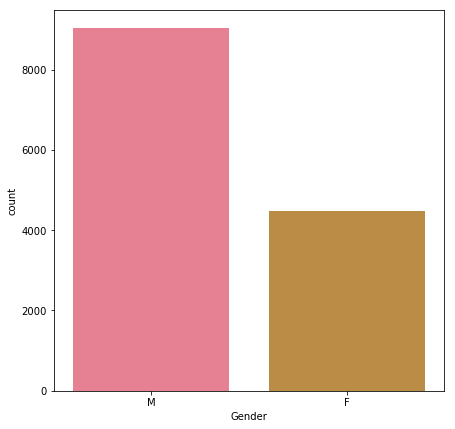

In [690]:
plt.rcParams['figure.figsize']=(7,7)
sns.countplot(df2.Gender,palette=sns.color_palette("husl", 8))


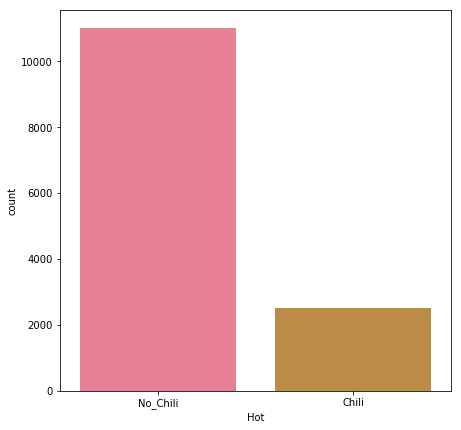

In [894]:
sns.countplot(df2.Hot,palette=sns.color_palette("husl", 8))


In [953]:
df2.Hot.value_counts()
2510/(10994+2510)

0.18587085308056872

(array([    0.,   250.,   500.,   750.,  1000.,  1250.,  1500.,  1750.,
         2000.,  2250.]), <a list of 10 Text yticklabel objects>)

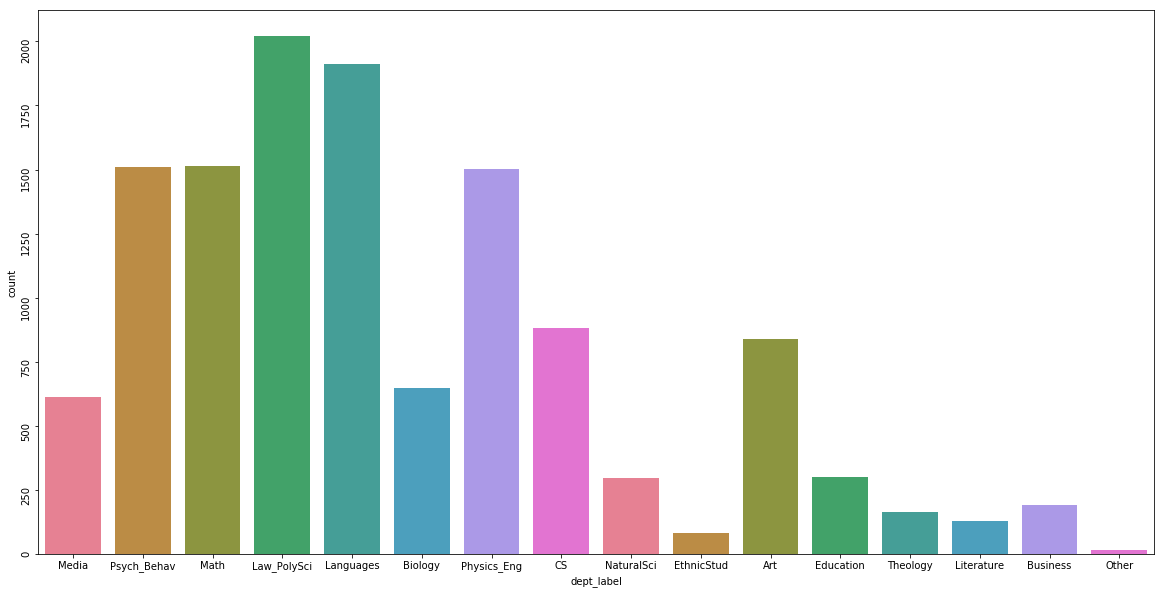

In [535]:

plt.rcParams['figure.figsize']=(20,10)
sns.countplot(df2.dept_label,palette=sns.color_palette("husl", 8))
plt.yticks(rotation=90) 



In [950]:
df2.dept_label.value_counts()

Law_PolySci    2020
Languages      1911
Math           1514
Psych_Behav    1509
Physics_Eng    1502
CS              880
Art             840
Biology         646
Media           614
Education       300
NaturalSci      295
Business        190
Theology        164
Literature      128
EthnicStud       82
Other            17
Name: dept_label, dtype: int64

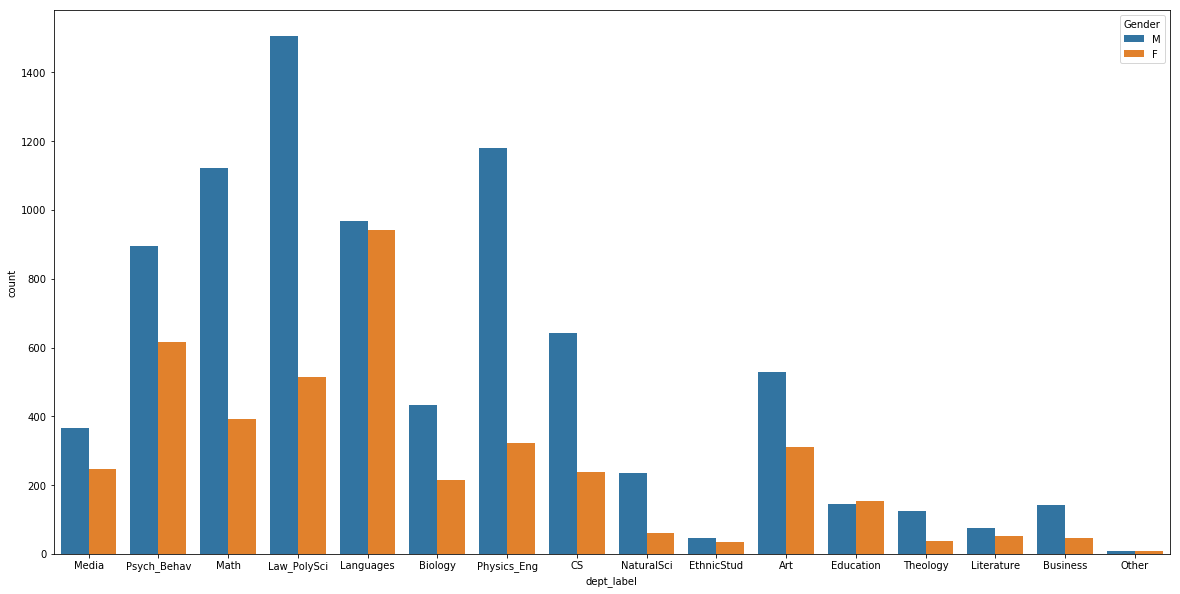

In [563]:
ax = sns.countplot(x="dept_label", hue="Gender", data=df)

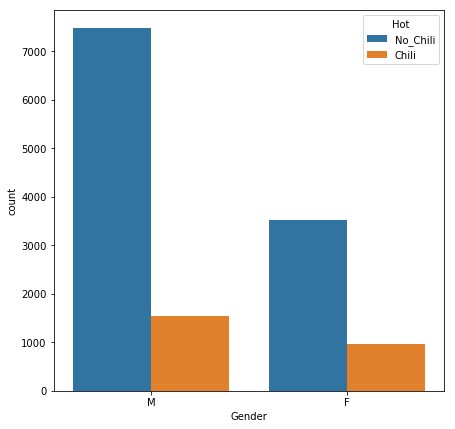

In [895]:
ax = sns.countplot(x="Gender", hue="Hot", data=df)

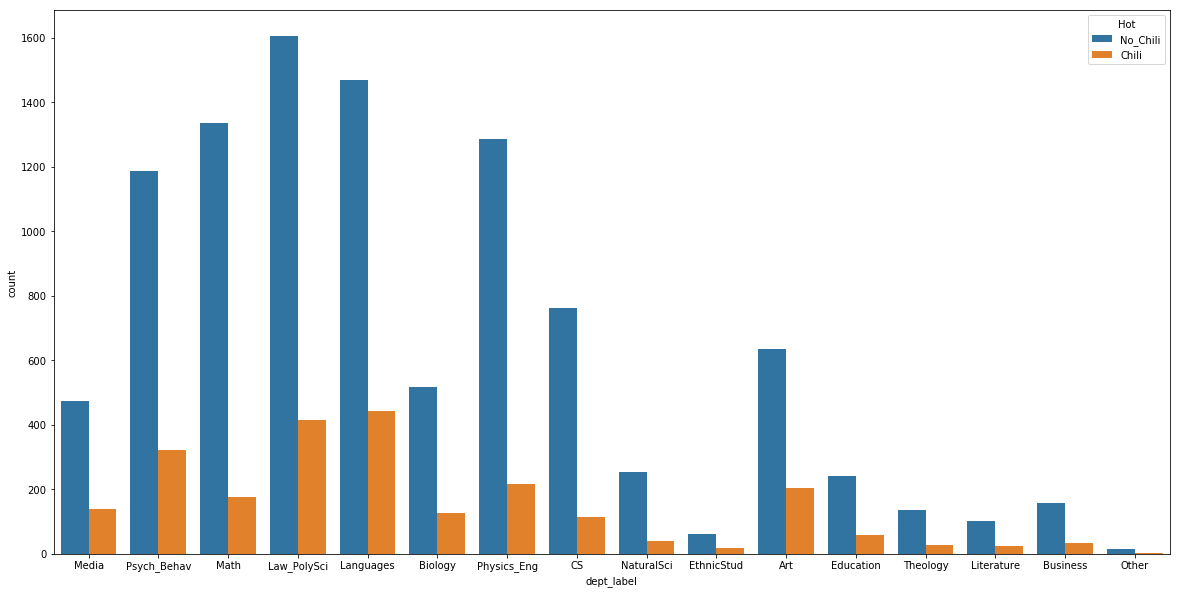

In [898]:
plt.rcParams['figure.figsize']=(20,10)

ax = sns.countplot(x="dept_label", hue="Hot", data=df)

In [ ]:
df2.update(df2[['Tag_0', 'Tag_1', 'Tag_2', 'Tag_3', 'Tag_4', 'Tag_5', 'Tag_6', 'Tag_7',
       'Tag_8', 'Tag_9', 'Tag_10', 'Tag_11', 'Tag_12', 'Tag_13', 'Tag_14',
       'Tag_15', 'Tag_16', 'Tag_17', 'Tag_18', 'Tag_19','Num_Ratings','TotalFeedback']].fillna(0))

In [1408]:
df2.Overall_Qual_scores[0:5]

0             [5.0, 4.5, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0]
1    [5.0, 4.0, 5.0, 5.0, 4.5, 4.5, 4.0, 4.0, 4.0, ...
2    [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, ...
3    [5.0, 4.5, 5.0, 5.0, 4.5, 5.0, 5.0, 4.5, 5.0, ...
4                  [4.5, 4.0, 4.0, 4.0, 5.0, 4.0, 4.0]
Name: Overall_Qual_scores, dtype: object

In [1410]:
print(df2.isnull().sum())

Num_Ratings_x                0
Tag_0_avg                    0
Tag_1_avg                    0
Tag_2_avg                    0
Tag_3_avg                    0
Tag_4_avg                    0
Tag_5_avg                    0
Tag_6_avg                    0
Tag_7_avg                    0
Tag_8_avg                    0
Tag_9_avg                    0
Tag_10_avg                   0
Tag_11_avg                   0
Tag_12_avg                   0
Tag_13_avg                   0
Tag_14_avg                   0
Tag_15_avg                   0
Tag_16_avg                   0
Tag_17_avg                   0
Tag_18_avg                   0
Tag_19_avg                   0
TotalFeedback_avg            0
Name                         0
Gender                       0
Comments                     0
Overall_Qual_scores          0
ProfID                       0
Subject                      0
City                         0
Difficulty                   0
                            ..
SocialScience                0
SocialWo

** Data exploration **

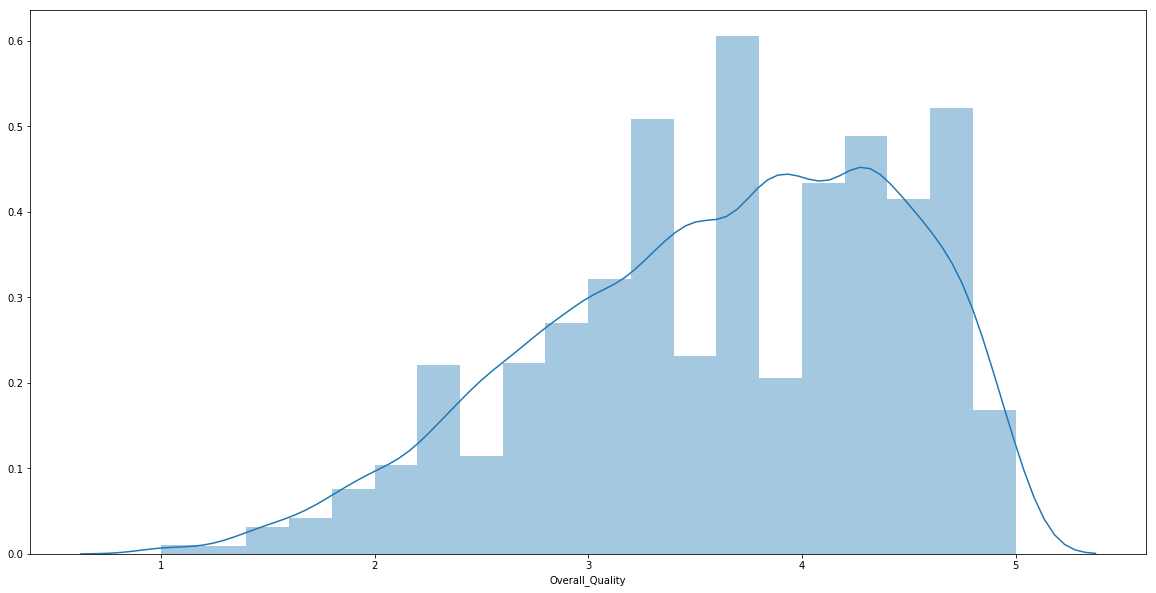

In [542]:
# PLOTTING DV (Overall_Quality) 
sns.distplot(df2['Overall_Quality'], bins = 20)

In [543]:
len(df2.State.unique())

59

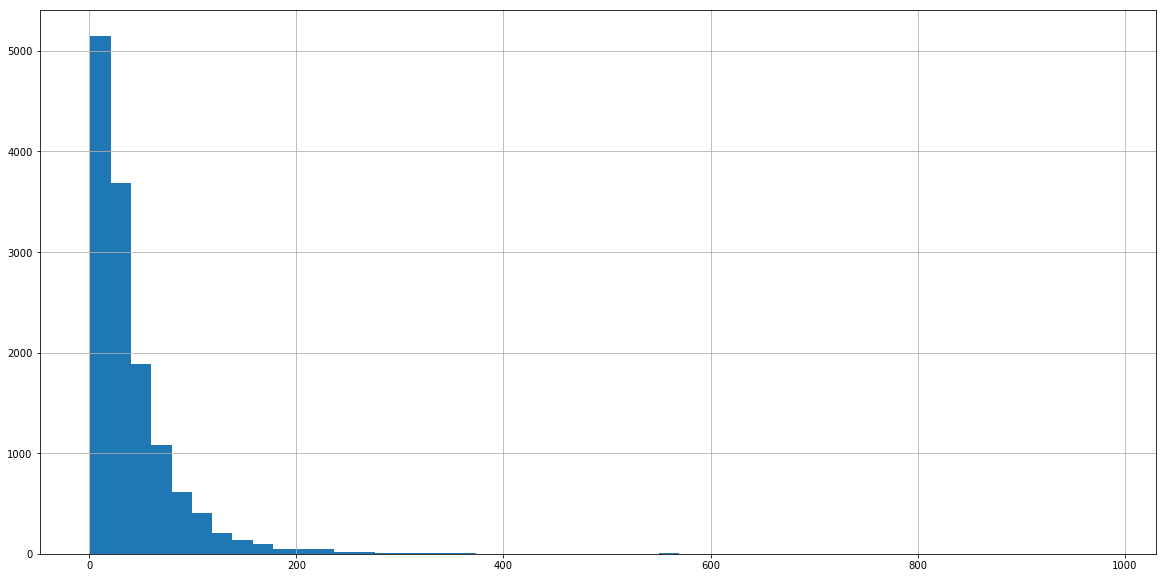

In [544]:
df2.Num_Ratings_x.hist(bins=50)

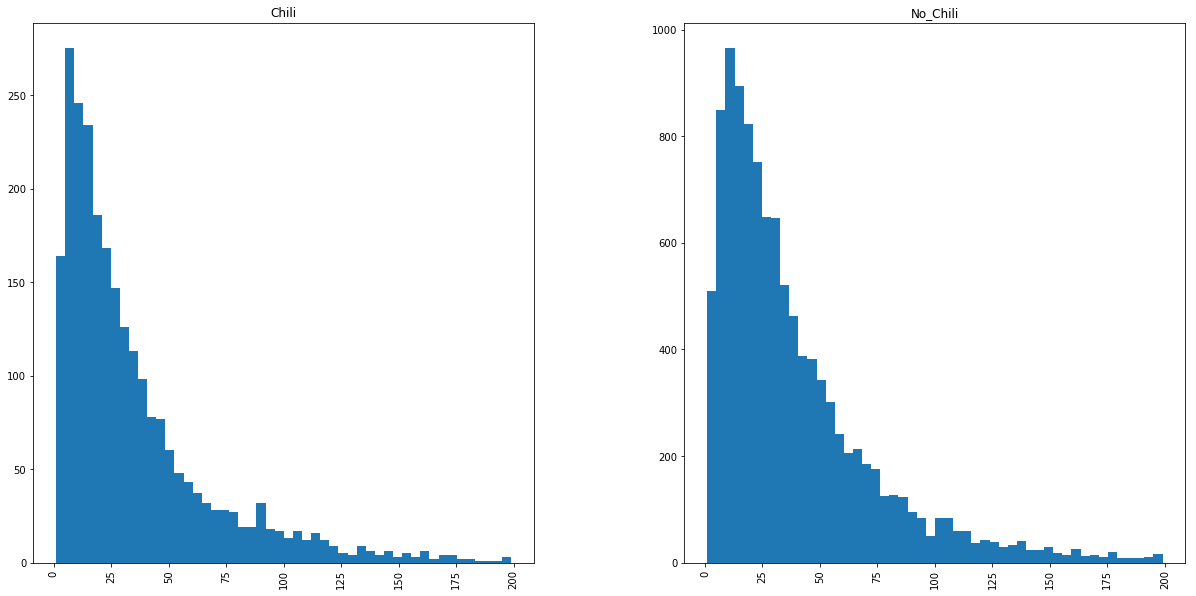

In [545]:
ax = df2[df2.Num_Ratings_x < 200].Num_Ratings_x.hist(bins = 50, by=df3.Hot)
plt.figure(figsize=(100, 100))


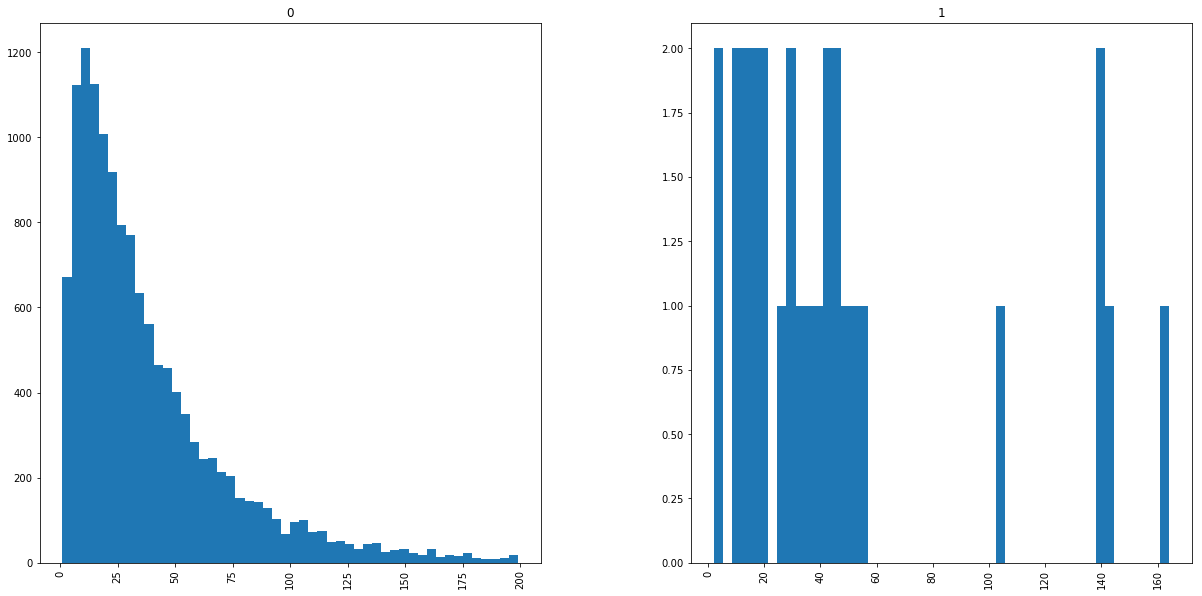

In [546]:
ax = df2[df2.Num_Ratings_x < 200].Num_Ratings_x.hist(bins = 50, by=df3.Gender)
plt.figure(figsize=(100, 100))



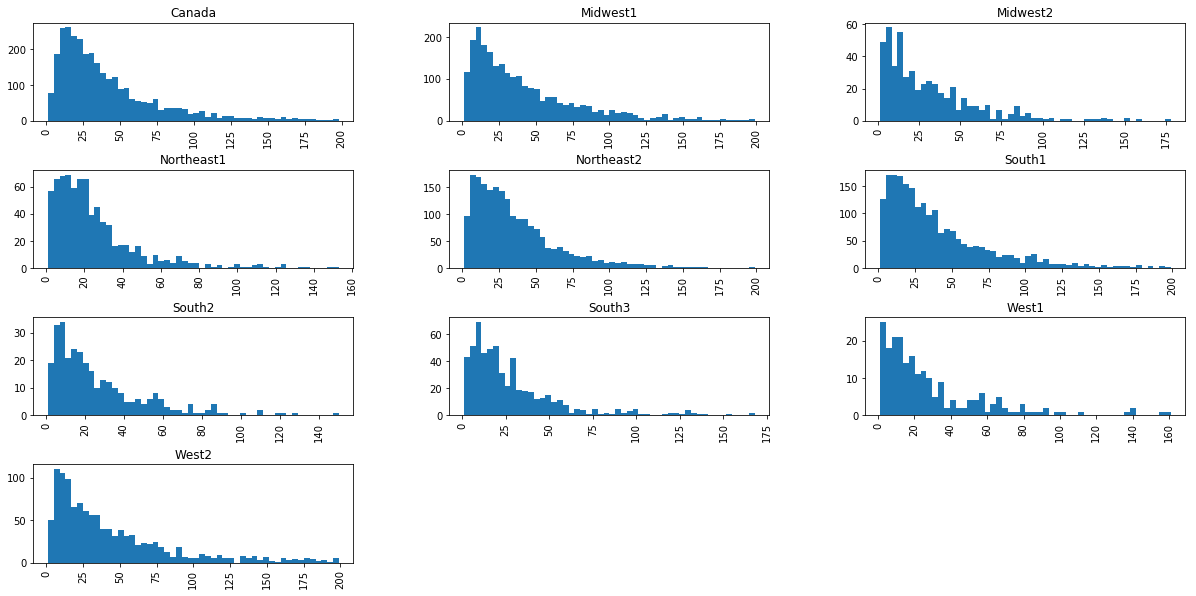

In [547]:
ax = df2[df2.Num_Ratings_x < 200].Num_Ratings_x.hist(bins = 50, by=df3.region_label)
plt.figure(figsize=(50, 20))


In [1411]:
df2.columns.tolist()

['Num_Ratings_x',
 'Tag_0_avg',
 'Tag_1_avg',
 'Tag_2_avg',
 'Tag_3_avg',
 'Tag_4_avg',
 'Tag_5_avg',
 'Tag_6_avg',
 'Tag_7_avg',
 'Tag_8_avg',
 'Tag_9_avg',
 'Tag_10_avg',
 'Tag_11_avg',
 'Tag_12_avg',
 'Tag_13_avg',
 'Tag_14_avg',
 'Tag_15_avg',
 'Tag_16_avg',
 'Tag_17_avg',
 'Tag_18_avg',
 'Tag_19_avg',
 'TotalFeedback_avg',
 'Name',
 'Gender',
 'Comments',
 'Overall_Qual_scores',
 'ProfID',
 'Subject',
 'City',
 'Difficulty',
 'Grade_Received',
 'Hot',
 'Num_Ratings_y',
 'Overall_Quality',
 'School',
 'State',
 'Tags',
 'TotalFeedback',
 'OQ_SEM',
 'Tag_0',
 'Tag_1',
 'Tag_2',
 'Tag_3',
 'Tag_4',
 'Tag_5',
 'Tag_6',
 'Tag_7',
 'Tag_8',
 'Tag_9',
 'Tag_10',
 'Tag_11',
 'Tag_12',
 'Tag_13',
 'Tag_14',
 'Tag_15',
 'Tag_16',
 'Tag_17',
 'Tag_18',
 'Tag_19',
 'Northeast1',
 'Northeast2',
 'Midwest1',
 'Midwest2',
 'South1',
 'South2',
 'South3',
 'West1',
 'West2',
 'Canada',
 'Art_x',
 'Biology_x',
 'Business_x',
 'CS',
 'Education_x',
 'EthnicStud',
 'Languages_x',
 'Law_PolySci',
 'L

In [1413]:
heat = df2[['Num_Ratings_x',
 'Tag_0_avg',
 'Tag_1_avg',
 'Tag_2_avg',
 'Tag_3_avg',
 'Tag_4_avg',
 'Tag_5_avg',
 'Tag_6_avg',
 'Tag_7_avg',
 'Tag_8_avg',
 'Tag_9_avg',
 'Tag_10_avg',
 'Tag_11_avg',
 'Tag_12_avg',
 'Tag_13_avg',
 'Tag_14_avg',
 'Tag_15_avg',
 'Tag_16_avg',
 'Tag_17_avg',
 'Tag_18_avg',
 'Tag_19_avg',
 'TotalFeedback_avg',
 'Difficulty',
 'Grade_Received',
 'Overall_Quality',
 'OQ_SEM',
 'Northeast1',
 'Northeast2',
 'Midwest1',
 'Midwest2',
 'South1',
 'South2',
 'South3',
 'West1',
 'West2',
 'Canada',
 'Art_x',
 'Biology_x',
 'Business_x',
 'CS',
 'Education_x',
 'EthnicStud',
 'Languages_x',
 'Law_PolySci',
 'Literature_x',
 'Math',
 'Media',
 'NaturalSci',
 'Physics_Eng',
 'Psych_Behav',
 'Theology_x',
 'Other',
 'Chili',
 'No_Chili',
 'F',
 'M']]

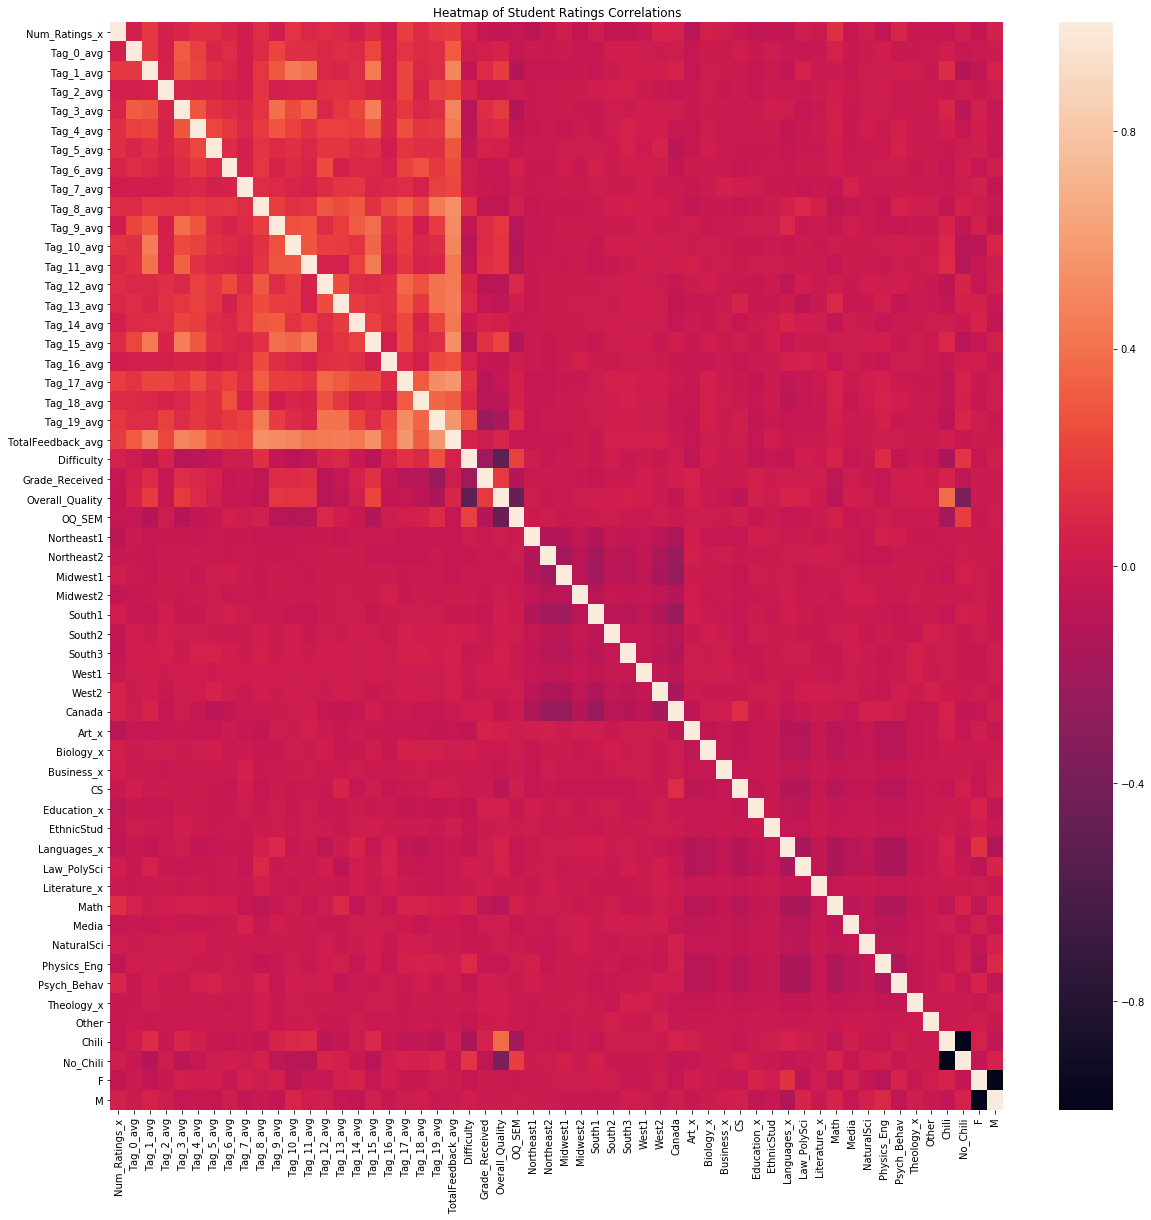

In [1415]:
# check multicollinearity among features 
plt.figure(figsize=(20, 20))
sns.heatmap(heat.corr(), annot=False)
plt.title("Heatmap of Student Ratings Correlations")

#  NLP 

In [1105]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk import word_tokenize   
from nltk.stem import WordNetLemmatizer 
from gensim import corpora, models, similarities, matutils


In [1099]:
 class LemmaTokenizer(object):
        def __init__(self):
            self.wnl = WordNetLemmatizer()
        def __call__(self, doc):
            return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

**LDA**

In [1111]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", tokenizer=LemmaTokenizer())
count_vectorizer.fit(df2['Comments'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
        tokenizer=<__main__.LemmaTokenizer object at 0x119ac9e80>,
        vocabulary=None)

In [1112]:
counts = count_vectorizer.transform(df2['Comments']).transpose()

In [1113]:
corpus = matutils.Sparse2Corpus(counts)

In [1114]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [1136]:
lda = models.LdaModel(corpus=corpus, num_topics=100, id2word=id2word, passes=7)

In [1135]:
lda.print_topics(num_words=20)

[(0,
  '0.000*"sigler" + 0.000*"dave" + 0.000*"bradshaw" + 0.000*"fricke" + 0.000*"fuchs" + 0.000*"luther" + 0.000*"prok" + 0.000*"brady" + 0.000*"decker" + 0.000*"dr. sigler" + 0.000*"klepper" + 0.000*"vera" + 0.000*"tyler" + 0.000*"moe" + 0.000*"val" + 0.000*"reid" + 0.000*"buckman" + 0.000*"dan" + 0.000*"borden" + 0.000*"balik"'),
 (1,
  '0.045*"." + 0.028*"," + 0.014*"class" + 0.012*"``" + 0.010*"test" + 0.008*"lecture" + 0.007*"n\'t" + 0.006*", ``" + 0.006*"exam" + 0.005*"`` ," + 0.005*". ``" + 0.004*"book" + 0.004*"note" + 0.004*"study" + 0.004*"question" + 0.004*"read" + 0.004*"hard" + 0.003*"\'s" + 0.003*"wa" + 0.003*"class ."'),
 (2,
  '0.045*"." + 0.034*"," + 0.016*"class" + 0.014*"``" + 0.007*", ``" + 0.006*"\'s" + 0.006*"`` ," + 0.006*"paper" + 0.005*"wa" + 0.005*". ``" + 0.005*"reading" + 0.005*"professor" + 0.004*"n\'t" + 0.004*"\'" + 0.004*"class ." + 0.004*"!" + 0.004*"\' ," + 0.003*"interesting" + 0.003*". \'" + 0.003*"lot"'),
 (3,
  '0.058*"." + 0.052*"," + 0.017*"``"

In [1141]:
lda_corpus = lda[corpus]

In [1166]:
lda_corpus

In [1142]:
lda_docs = [doc for doc in lda_corpus]

In [1194]:
lda_docs[0:3]

[[(28, 0.54228319871238795),
  (39, 0.14817130713832563),
  (88, 0.30271308933511898)],
 [(28, 0.073547326341654423),
  (39, 0.25353330763800563),
  (88, 0.50823557998288305),
  (93, 0.15534003157939158)],
 [(28, 0.33721205181117392),
  (46, 0.18656367990127032),
  (48, 0.084053191489361828),
  (88, 0.010267321358023029),
  (93, 0.37876545756783114)]]

In [1195]:
components_columns = []
for i in range(100):
    components_columns.append("LDA_topic"+str(i))

In [1196]:
probMatrix = np.zeros(shape=(13504,100))  # size of (num docs, k topics)

for doc_num, probs in enumerate(lda_docs):
    for k_index, prob in probs:
        probMatrix[doc_num, k_index] = prob


In [1201]:
LDA_data = pd.DataFrame(probMatrix, columns = components_columns)

In [1204]:
dfLDA = pd.concat([df2, LDA_data], axis=1)

In [1218]:
dfLDA.isnull().sum()
dfLDA1 = dfLDA.dropna()


In [1470]:
df2.head()

,Num_Ratings_x,Tag_0_avg,Tag_1_avg,Tag_2_avg,Tag_3_avg,Tag_4_avg,Tag_5_avg,Tag_6_avg,Tag_7_avg,Tag_8_avg,...,VeterinarySciences,Visual&PerformingArts,VisualArts,Women,Women'sStudies,Womens&GenderStudies,WorldLanguages&Cultures,Writing,YouthMinistry,Zoology
0,50.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,99.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,169.0,0.0,0.04142,0.0,0.017751,0.017751,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,88.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,51.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [1219]:
X=dfLDA1[['Num_Ratings_x',
 'Tag_0_avg',
 'Tag_1_avg',
 'Tag_2_avg',
 'Tag_3_avg',
 'Tag_4_avg',
 'Tag_5_avg',
 'Tag_6_avg',
 'Tag_7_avg',
 'Tag_8_avg',
 'Tag_9_avg',
 'Tag_10_avg',
 'Tag_11_avg',
 'Tag_12_avg',
 'Tag_13_avg',
 'Tag_14_avg',
 'Tag_15_avg',
 'Tag_16_avg',
 'Tag_17_avg',
 'Tag_18_avg',
 'Tag_19_avg',
 'TotalFeedback_avg',
 'Difficulty',
 'Grade_Received',
 'Northeast1',
 'Northeast2',
 'Midwest1',
 'Midwest2',
 'South1',
 'South2',
 'South3',
 'West1',
 'West2',
 'Canada',
 'Art_x',
 'Biology_x',
 'Business_x',
 'CS',
 'Education_x',
 'EthnicStud',
 'Languages_x',
 'Law_PolySci',
 'Literature_x',
 'Math',
 'Media',
 'NaturalSci',
 'Physics_Eng',
 'Psych_Behav',
 'Theology_x',
 'Other',
 'Chili',
 'No_Chili',
 'F',
 'M',
 'LDA_topic0',
 'LDA_topic1',
 'LDA_topic2',
 'LDA_topic3',
 'LDA_topic4',
 'LDA_topic5',
 'LDA_topic6',
 'LDA_topic7',
 'LDA_topic8',
 'LDA_topic9',
 'LDA_topic10',
 'LDA_topic11',
 'LDA_topic12',
 'LDA_topic13',
 'LDA_topic14',
 'LDA_topic15',
 'LDA_topic16',
 'LDA_topic17',
 'LDA_topic18',
 'LDA_topic19',
 'LDA_topic20',
 'LDA_topic21',
 'LDA_topic22',
 'LDA_topic23',
 'LDA_topic24',
 'LDA_topic25',
 'LDA_topic26',
 'LDA_topic27',
 'LDA_topic28',
 'LDA_topic29',
 'LDA_topic30',
 'LDA_topic31',
 'LDA_topic32',
 'LDA_topic33',
 'LDA_topic34',
 'LDA_topic35',
 'LDA_topic36',
 'LDA_topic37',
 'LDA_topic38',
 'LDA_topic39',
 'LDA_topic40',
 'LDA_topic41',
 'LDA_topic42',
 'LDA_topic43',
 'LDA_topic44',
 'LDA_topic45',
 'LDA_topic46',
 'LDA_topic47',
 'LDA_topic48',
 'LDA_topic49',
 'LDA_topic50',
 'LDA_topic51',
 'LDA_topic52',
 'LDA_topic53',
 'LDA_topic54',
 'LDA_topic55',
 'LDA_topic56',
 'LDA_topic57',
 'LDA_topic58',
 'LDA_topic59',
 'LDA_topic60',
 'LDA_topic61',
 'LDA_topic62',
 'LDA_topic63',
 'LDA_topic64',
 'LDA_topic65',
 'LDA_topic66',
 'LDA_topic67',
 'LDA_topic68',
 'LDA_topic69',
 'LDA_topic70',
 'LDA_topic71',
 'LDA_topic72',
 'LDA_topic73',
 'LDA_topic74',
 'LDA_topic75',
 'LDA_topic76',
 'LDA_topic77',
 'LDA_topic78',
 'LDA_topic79',
 'LDA_topic80',
 'LDA_topic81',
 'LDA_topic82',
 'LDA_topic83',
 'LDA_topic84',
 'LDA_topic85',
 'LDA_topic86',
 'LDA_topic87',
 'LDA_topic88',
 'LDA_topic89',
 'LDA_topic90',
 'LDA_topic91',
 'LDA_topic92',
 'LDA_topic93',
 'LDA_topic94',
 'LDA_topic95',
 'LDA_topic96',
 'LDA_topic97',
 'LDA_topic98',
 'LDA_topic99']]
y=dfLDA1['Overall_Quality']

In [1220]:
X,holdoutX,y,holdouty = model_selection.train_test_split(X,y,test_size = .1)

models = {}
parameters = {}

models['linear_model'] = linear_model.LinearRegression()
models['ridge_model'] = linear_model.Ridge()
models['lasso_model'] = linear_model.Lasso(alpha=.5)
models['robust_regression'] = linear_model.SGDRegressor(loss='huber',n_iter=20)
models['eps_insensitive'] = linear_model.SGDRegressor(loss='epsilon_insensitive',n_iter=20)


models['cart'] = tree.DecisionTreeRegressor(max_depth=7)
models['extratrees'] = tree.ExtraTreeRegressor(max_depth=7)
models['randomForest'] = ensemble.RandomForestRegressor()
models['adaboostedTrees'] = ensemble.AdaBoostRegressor()
models['gradboostedTrees'] = ensemble.GradientBoostingRegressor()


for name,model in models.items():
    scores = model_selection.cross_val_score(model, X, y, n_jobs=1)
    print('Model: '+name)
    print("Score: " + str(np.mean(scores)))
    print()

/Users/kellygola/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/kellygola/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Model: linear_model
Score: 0.683394375107

Model: ridge_model
Score: 0.690851254934

Model: lasso_model
Score: -2.5193400306e-05

Model: robust_regression
Score: -7.14950120709

Model: eps_insensitive
Score: -16.7104421348

Model: cart
Score: 0.619484571953

Model: extratrees
Score: 0.603529148374

Model: randomForest
Score: 0.680269163157

Model: adaboostedTrees
Score: 0.63956267765

Model: gradboostedTrees
Score: 0.72760723411



**LSA**

In [1442]:
df2.columns.tolist()

['Num_Ratings_x',
 'Tag_0_avg',
 'Tag_1_avg',
 'Tag_2_avg',
 'Tag_3_avg',
 'Tag_4_avg',
 'Tag_5_avg',
 'Tag_6_avg',
 'Tag_7_avg',
 'Tag_8_avg',
 'Tag_9_avg',
 'Tag_10_avg',
 'Tag_11_avg',
 'Tag_12_avg',
 'Tag_13_avg',
 'Tag_14_avg',
 'Tag_15_avg',
 'Tag_16_avg',
 'Tag_17_avg',
 'Tag_18_avg',
 'Tag_19_avg',
 'TotalFeedback_avg',
 'Name',
 'Gender',
 'Comments',
 'Overall_Qual_scores',
 'ProfID',
 'Subject',
 'City',
 'Difficulty',
 'Grade_Received',
 'Hot',
 'Num_Ratings_y',
 'Overall_Quality',
 'School',
 'State',
 'Tags',
 'TotalFeedback',
 'OQ_SEM',
 'Tag_0',
 'Tag_1',
 'Tag_2',
 'Tag_3',
 'Tag_4',
 'Tag_5',
 'Tag_6',
 'Tag_7',
 'Tag_8',
 'Tag_9',
 'Tag_10',
 'Tag_11',
 'Tag_12',
 'Tag_13',
 'Tag_14',
 'Tag_15',
 'Tag_16',
 'Tag_17',
 'Tag_18',
 'Tag_19',
 'Northeast1',
 'Northeast2',
 'Midwest1',
 'Midwest2',
 'South1',
 'South2',
 'South3',
 'West1',
 'West2',
 'Canada',
 'Art_x',
 'Biology_x',
 'Business_x',
 'CS',
 'Education_x',
 'EthnicStud',
 'Languages_x',
 'Law_PolySci',
 'L

In [1443]:
tfidf = TfidfVectorizer(ngram_range=(1, 4),stop_words='english', max_df = .8, min_df=5, tokenizer=LemmaTokenizer())
comment_mat = tfidf.fit_transform(df2['Comments'])

In [1444]:
# Dimensionality of output data. TRY LDA NEXT

lsa = TruncatedSVD(100, n_iter = 10)
reduced_mat = lsa.fit_transform(comment_mat)

In [1445]:
def get_topical_terms(topic_mat, topic_num, term_vec, num_terms=25):
    return term_vec[np.argsort(-topic_mat[topic_num,:])][:num_terms]

In [1446]:
terms = np.array(tfidf.get_feature_names())

In [1447]:
for i in range(100):
    print("component {}".format(i))
    print(get_topical_terms(lsa.components_,i,terms, 35))

component 0
['test' '! !' 'professor' 'lecture' 'teacher' 'easy' 'really' '`` , ``'
 'student' 'make' 'hard' 'great' '&' ';' '. `` , ``' 'exam' 'doe' 'lot'
 'know' 'guy' 'course' '...' '! ! !' 'help' 'just' 'time' 'interesting'
 'work' 'prof' 'grade' 'like' "''" 'question' 'note' 'best']
component 1
["comment '" "'no comment '" "'no comment" "'no" 'comment'
 ", 'no comment '" ", 'no comment" ", 'no" "' , 'no comment" "' , 'no"
 "comment ' ," "'no comment ' ," "comment ' , 'no" "'no comment ' ]"
 "comment ' ]" "[ 'no comment '" "[ 'no comment" "[ 'no" "' ]" ". ' , 'no"
 "comment ' , ``" "! ' , 'no" "`` , 'no comment" "`` , 'no" ". `` , 'no"
 '...' '! !' "! '" "'' , 'no comment" "'' , 'no" "! ' ," '! ! !' '& #'
 '# 63' '& # 63']
component 2
[';' '&' 'quot ;' 'quot' '& quot ;' '& quot' '! !' '! ! !' '! ! ! !' '& #'
 '#' '# 63' '& # 63' '& # 63 ;' '63 ;' '# 63 ;' '63' '; &' '...' '# 63 ; &'
 '63 ; &' '; & #' '; & # 63' '63 ; & #' '; & quot' '; & quot ;' 'teacher'
 "! ! '" '& quot ; &' 'quo

['lab' 'test' 'best' '...' '. lab' 'online' '. test' 'prof' 'hard' 'lab .'
 "'ve" 'history' 'professor' "! '" 'physic' "! ' ," 'best prof'
 'best professor' 'homework' '`` best' ', `` best' 'test .' 'lab ,'
 ', test' "'the" ", 'the" 'interesting' 'worst' 'quiz' ', lab' 'took'
 'test hard' 'taken' 'boring' 'week']
component 26
['quiz' 'history' 'online' 'student' '`` , ``' 'help' 'best' 'care' 'doe'
 'professor' 'prof' "doe n't" 'test' '. `` , ``' 'helpful' 'note' 'nice'
 'care student' 'question' "'ve" 'guide' 'student .' 'willing'
 'study guide' 'quiz .' '. quiz' 'willing help' ", 'very" 'know' "'very"
 'answer' 'french' 'music' '`` best' 'essay']
component 27
["'great" 'history' ", 'great" "' , 'great" 'doe' 'prof' 'lab' "doe n't"
 'project' 'math' 'quiz' ". ' , 'great" 'art' '. doe' 'group' 'know'
 "'great prof" 'prof !' "'great teacher" ", 'great teacher" ", 'great prof"
 'worst' "! '" 'french' "! ' ," "'great professor" "`` , 'great"
 "' , 'great teacher" ", 'great professor" ". d

 'marker .' 'boring' 'story' 'writing' '%' "did n't"]
component 49
['french' 'online' '...' 'student' 'accent' 'care' 'french .' 'make'
 'funny' 'math' 'care student' 'hard' 'language' 'french ,' 'book'
 '! ! ! !' 'midterm' 'read' "'no comment ' ," "comment ' ," 'fun'
 'student .' 'understand' "'good" 'know' ", 'good" "comment ' , 'no"
 'french class' 'paper' 'stuff' "' , 'good" 'know stuff' 'boring'
 'hard understand' 'online class']
component 50
['...' 'lecture' 'physic' 'hard' 'work' '... ...' 'understand'
 '... ... ...' 'paper' 'lecture .' 'recommend' 'learn' 'quiz'
 'hard understand' 'highly' 'story' '... ... ... ...' 'lot'
 'highly recommend' 'speech' 'really' "... '" 'ta' '. lecture' 'chemistry'
 'accent' 'teach' 'know' "... ' ," 'lady' "'no comment ' ]" "comment ' ]"
 'follow' 'talking' 'passionate']
component 51
['question' 'project' 'philosophy' 'help' 'physic' 'understand' 'group'
 'ask' 'willing' 'answer' 'essay' 'willing help' 'accent' 'hard understand'
 'best' 'group proj

 "' , 'i" 'willing help' 'movie' 'interesting' 'grader ,']
component 73
[')' '(' "'one" 'assignment' ", 'one" 'writing' 'history' "' , 'one"
 "'one best" ", 'one best" 'chemistry' 'question' ') .' 'read' 'work'
 "' , 'one best" 'chem' 'highly' 'interesting' ':' "'nice" ", 'nice" 'dr.'
 'book' '. highly' 'fair' 'read book' 'paper' 'midterm' 'homework' '...'
 '`` dr.' 'textbook' 'study guide' 'discussion']
component 74
['physic' 'ta' 'recommend' 'work' 'dr.' 'highly' 'doe' 'funny' 'reading'
 'highly recommend' "'this" 'helpful' ", 'this" 'story' "doe n't"
 '. highly' 'fine' "' , 'this" '. highly recommend' 'fine .' 'hour'
 '`` dr.' ')' '(' "'ll fine" ', `` dr.' 'boring' "'awesome" "'ll"
 'office hour' 'office' "'she" 'lot' '. ta' 'recommend .']
component 75
['film' 'movie' 'ta' "'one" ", `` 's" ", 'one" "`` 's" "' , 'one"
 "'excellent" "'one best" 'homework' ", 'one best" ", 'excellent" 'fun'
 "' , 'one best" 'work' 'book' "' , `` 's" "' , 'excellent" '`` , ``'
 "`` , `` 's" 'essay' "com

['film' 'movie' "'best" 'grade' ", 'best" "'nice" ", 'nice" 'story'
 "' , 'nice" "'a" "' , 'best" ", 'a" 'accounting' "'nice guy" ", 'nice guy"
 "' , 'a" 'problem' 'man' 'understand' 'econ' "' , 'nice guy" 'band'
 'reading' 'taken' 'project' 'mark' ':' 'took' "'best teacher" 'instructor'
 'note' 'doe' 'watch' 'grade .' 'grading']
component 96
['helpful' 'material' 'film' 'writing' 'open' 'love' ', helpful'
 'helpful ,' 'helpful .' 'grade' 'movie' 'writer' 'reading' 'fair'
 'material .' 'worst' 'computer' 'open book' 'know' 'stats' 'philosophy'
 'marker' 'slide' 'understand' 'textbook' 'talking' '. helpful' 'psych'
 'grade .' 'u' 'tell' 'funny' 'want' ', helpful ,' 'programming']
component 97
['avoid' 'review' 'slide' 'english' 'helpful' '. avoid' 'sheet' 'stats'
 'work' 'just' 'doe' 'cost' 'textbook' 'did' 'ta' '! ! ! !' 'smart'
 "did n't" 'cheat' 'extremely' 'cheat sheet' 'open' "doe n't" "'best"
 'opinion' 'stuff' 'time' 'avoid cost' ", 'best" 'story' 'let' 'helpful .'
 'guy' ", `` '

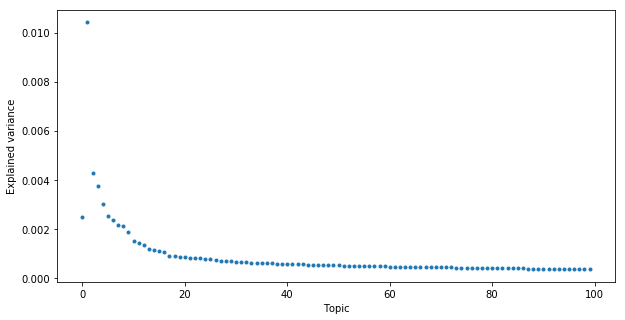

In [1448]:
fig, ax = plt.subplots()
ax.plot(lsa.explained_variance_ratio_,'.')
ax.set_ylabel("Explained variance")
ax.set_xlabel("Topic");

In [1449]:
column_names = []
for i in range(100):
    column_names.append("component_"+str(i+1))

In [1469]:
components = pd.DataFrame(reduced_mat, columns = column_names)

In [1471]:
df3 = pd.concat([df2, components], axis=1)

In [1472]:
df3.head(20)

,Num_Ratings_x,Tag_0_avg,Tag_1_avg,Tag_2_avg,Tag_3_avg,Tag_4_avg,Tag_5_avg,Tag_6_avg,Tag_7_avg,Tag_8_avg,...,component_91,component_92,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100
0,50.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.018542,0.018774,-0.009074,-0.013262,-0.005136,0.030255,0.021312,-0.018810,0.017506,-0.003785
1,99.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,-0.005888,0.003674,0.028167,0.009845,0.032166,-0.013368,-0.004717,-0.020346,-0.025255,-0.017792
2,169.0,0.000000,0.041420,0.0,0.017751,0.017751,0.000000,0.0,0.000000,0.000000,...,0.000496,0.012156,0.008327,0.018419,0.027129,0.012298,-0.025322,-0.005515,0.005277,0.028864
3,88.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.051376,-0.001527,0.024655,0.000088,0.011639,-0.018891,-0.015650,-0.002106,-0.003836,0.001840
4,51.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.083126,0.025584,-0.025441,0.017974,0.002031,0.051682,0.015748,-0.007417,0.000458,0.013120
5,47.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.002703,-0.021832,0.019484,-0.020164,-0.006097,0.012548,-0.003308,-0.027737,0.026604,-0.015286
6,39.0,0.000000,0.000000,0.0,0.000000,0.051282,0.000000,0.0,0.000000,0.025641,...,-0.018073,-0.010315,0.003979,-0.016321,-0.005913,0.019125,0.005920,-0.001002,-0.007990,-0.012678
7,47.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,-0.012650,0.016783,0.036058,-0.004615,-0.000912,-0.001557,-0.028818,0.010590,-0.006742,0.026584
8,52.0,0.000000,0.000000,0.0,0.000000,0.057692,0.038462,0.0,0.000000,0.038462,...,0.013523,-0.039158,0.016785,-0.034186,0.000648,0.049971,0.011618,0.004667,0.018144,-0.007206
9,4.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,-0.000944,-0.001549,0.009975,0.005315,-0.012554,0.000098,0.016903,-0.005061,0.008879,-0.019134


In [1506]:
df4 = df3.dropna()
print(X.isnull().sum().tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5304, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Compare Models 

In [ ]:
df2.tolist()

In [1437]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import linear_model,ensemble, tree, model_selection
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score


In [1438]:
#df_avgs = df_avg.dropna()
#df3 = df3.apply(pd.to_numeric, errors='ignore')

In [1508]:
dfLSA=df3[['Tag_0_avg',
 'Tag_1_avg',
 'Tag_2_avg',
 'Tag_3_avg',
 'Tag_4_avg',
 'Tag_5_avg',
 'Tag_6_avg',
 'Tag_7_avg',
 'Tag_8_avg',
 'Tag_9_avg',
 'Tag_10_avg',
 'Tag_11_avg',
 'Tag_12_avg',
 'Tag_13_avg',
 'Tag_14_avg',
 'Tag_15_avg',
 'Tag_16_avg',
 'Tag_17_avg',
 'Tag_18_avg',
 'Tag_19_avg',
 'TotalFeedback_avg',
 'Difficulty',
 'Grade_Received',
 'Northeast1',
 'Northeast2',
 'Midwest1',
 'Midwest2',
 'South1',
 'South2',
 'South3',
 'West1',
 'West2',
 'Canada',
 'Art_x',
 'Biology_x',
 'Business_x',
 'CS',
 'Education_x',
 'EthnicStud',
 'Languages_x',
 'Law_PolySci',
 'Literature_x',
 'Math',
 'Media',
 'NaturalSci',
 'Physics_Eng',
 'Psych_Behav',
 'Theology_x',
 'Other',
 'Chili',
 'No_Chili',
 'F',
 'M',
 'component_1',
 'component_2',
 'component_3',
 'component_4',
 'component_5',
 'component_6',
 'component_7',
 'component_8',
 'component_9',
 'component_10',
 'component_11',
 'component_12',
 'component_13',
 'component_14',
 'component_15',
 'component_16',
 'component_17',
 'component_18',
 'component_19',
 'component_20',
 'component_21',
 'component_22',
 'component_23',
 'component_24',
 'component_25',
 'component_26',
 'component_27',
 'component_28',
 'component_29',
 'component_30',
 'component_31',
 'component_32',
 'component_33',
 'component_34',
 'component_35',
 'component_36',
 'component_37',
 'component_38',
 'component_39',
 'component_40',
 'component_41',
 'component_42',
 'component_43',
 'component_44',
 'component_45',
 'component_46',
 'component_47',
 'component_48',
 'component_49',
 'component_50',
 'component_51',
 'component_52',
 'component_53',
 'component_54',
 'component_55',
 'component_56',
 'component_57',
 'component_58',
 'component_59',
 'component_60',
 'component_61',
 'component_62',
 'component_63',
 'component_64',
 'component_65',
 'component_66',
 'component_67',
 'component_68',
 'component_69',
 'component_70',
 'component_71',
 'component_72',
 'component_73',
 'component_74',
 'component_75',
 'component_76',
 'component_77',
 'component_78',
 'component_79',
 'component_80',
 'component_81',
 'component_82',
 'component_83',
 'component_84',
 'component_85',
 'component_86',
 'component_87',
 'component_88',
 'component_89',
 'component_90',
 'component_91',
 'component_92',
 'component_93',
 'component_94',
 'component_95',
 'component_96',
 'component_97',
 'component_98',
 'component_99',
 'component_100','Overall_Quality']]

In [1534]:
dfLSA.shape
dfLSA = dfLSA.dropna()

In [1535]:
X = dfLSA.iloc[:,0:153].dropna()
y = dfLSA['Overall_Quality']
print(X.isnull().sum())

Tag_0_avg            0
Tag_1_avg            0
Tag_2_avg            0
Tag_3_avg            0
Tag_4_avg            0
Tag_5_avg            0
Tag_6_avg            0
Tag_7_avg            0
Tag_8_avg            0
Tag_9_avg            0
Tag_10_avg           0
Tag_11_avg           0
Tag_12_avg           0
Tag_13_avg           0
Tag_14_avg           0
Tag_15_avg           0
Tag_16_avg           0
Tag_17_avg           0
Tag_18_avg           0
Tag_19_avg           0
TotalFeedback_avg    0
Difficulty           0
Grade_Received       0
Northeast1           0
Northeast2           0
Midwest1             0
Midwest2             0
South1               0
South2               0
South3               0
                    ..
component_71         0
component_72         0
component_73         0
component_74         0
component_75         0
component_76         0
component_77         0
component_78         0
component_79         0
component_80         0
component_81         0
component_82         0
component_8

In [1536]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [1537]:
X,holdoutX,y,holdouty = model_selection.train_test_split(X,y,test_size = .1)

models = {}
parameters = {}

models['linear_model'] = linear_model.LinearRegression()
models['ridge_model'] = linear_model.Ridge()
models['lasso_model'] = linear_model.Lasso(alpha=.5)
models['robust_regression'] = linear_model.SGDRegressor(loss='huber',n_iter=20)
models['eps_insensitive'] = linear_model.SGDRegressor(loss='epsilon_insensitive',n_iter=20)


models['cart'] = tree.DecisionTreeRegressor(max_depth=7)
models['extratrees'] = tree.ExtraTreeRegressor(max_depth=7)
models['randomForest'] = ensemble.RandomForestRegressor()
models['adaboostedTrees'] = ensemble.AdaBoostRegressor()
models['gradboostedTrees'] = ensemble.GradientBoostingRegressor()


for name,model in models.items():
    scores = model_selection.cross_val_score(model, X, y, n_jobs=1)
    print('Model: '+name)
    print("Score: " + str(np.mean(scores)))
    print()

/Users/kellygola/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/kellygola/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Model: linear_model
Score: 0.765583968283

Model: ridge_model
Score: 0.763039301077

Model: lasso_model
Score: -0.000374872024755

Model: robust_regression
Score: 0.0591695895905

Model: eps_insensitive
Score: 0.50636831398

Model: cart
Score: 0.533961870229

Model: extratrees
Score: 0.48529820159

Model: randomForest
Score: 0.655383400094

Model: adaboostedTrees
Score: 0.639980786101

Model: gradboostedTrees
Score: 0.736391235885



In [1538]:
lm = linear_model.Lasso(alpha=18)
lm.fit(X_train,y_train)

Lasso(alpha=18, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [1539]:
train_set_pred1 = lm.predict(X_train)
test_set_pred1 = lm.predict(X_test)
print(np.sqrt(np.mean((test_set_pred1 - y_test)**2)))
print(r2_score(y_test, test_set_pred1))

0.804188332636
-3.99256150403e-05


In [1540]:
lm = linear_model.Ridge(alpha=1)
gb = ensemble.GradientBoostingRegressor()
lm.fit(X_train,y_train)
gb.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [1541]:
train_set_pred1 = lm.predict(X_train)
train_set_pred2 = gb.predict(X_train)
test_set_pred1 = lm.predict(X_test)
test_set_pred2 = gb.predict(X_test)

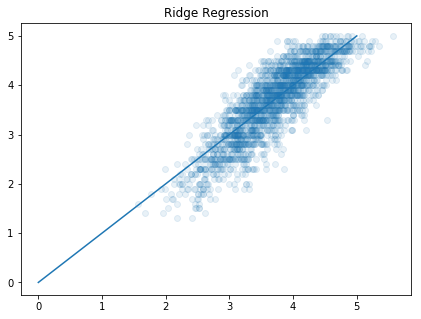

In [1458]:
plt.rcParams['figure.figsize']=(7,5)
plt.title('Ridge Regression')
plt.scatter(test_set_pred1,y_test,alpha=.1)
plt.plot(np.linspace(0,5,10),np.linspace(0,5,10))

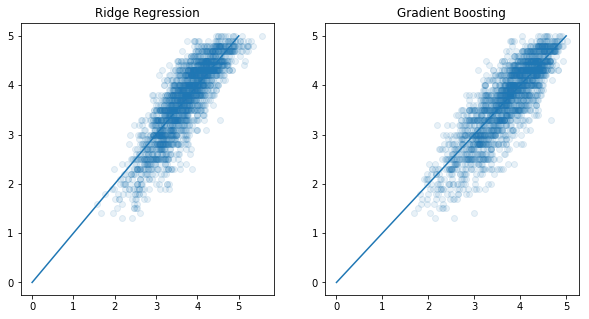

In [1459]:
plt.rcParams['figure.figsize']=(10,5)
plt.subplot(121)
plt.title('Ridge Regression')
plt.scatter(test_set_pred1,y_test,alpha=.1)
plt.plot(np.linspace(0,5,10),np.linspace(0,5,10))
plt.subplot(122)
plt.title('Gradient Boosting')
plt.scatter(test_set_pred2,y_test,alpha=.1)
plt.plot(np.linspace(0,5,10),np.linspace(0,5,10))

In [1542]:
print(np.sqrt(np.mean((test_set_pred1 - y_test)**2)))
print(r2_score(y_test, test_set_pred1))
print(np.sqrt(np.mean((test_set_pred2 - y_test)**2)))
print(r2_score(y_test, test_set_pred2))

0.395543365694
0.758069840088
0.415343328695
0.733242719356


In [1545]:
sorted(list(zip(X_train.columns, lm.coef_)), key = lambda x: x[1], reverse=True)

[('component_9', 4.9562424066713566),
 ('component_4', 2.3200717606299399),
 ('component_16', 2.097077191113494),
 ('component_10', 1.6609723565362193),
 ('component_24', 1.5510017873804232),
 ('component_11', 1.406656508560632),
 ('component_20', 1.3978786487806678),
 ('component_7', 1.3404256232385348),
 ('component_34', 1.0733562732883526),
 ('component_6', 0.87507873810818571),
 ('component_17', 0.80750088158615907),
 ('component_8', 0.7848312666837215),
 ('component_44', 0.78228934654692905),
 ('component_94', 0.77221485325667638),
 ('component_66', 0.75874418039878178),
 ('Tag_15_avg', 0.73994753562608317),
 ('component_64', 0.69711132308116663),
 ('component_90', 0.68976547108246566),
 ('component_63', 0.67995456876015437),
 ('component_69', 0.646644854323708),
 ('Tag_9_avg', 0.59834533965954695),
 ('component_70', 0.56488308879814686),
 ('component_26', 0.54604889130607681),
 ('component_13', 0.53786252012172853),
 ('component_55', 0.52135524074976802),
 ('component_82', 0.4875

In [1544]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df.nlargest(20, 'Coefficient')

,Coefficient
component_9,4.956242
component_4,2.320072
component_16,2.097077
component_10,1.660972
component_24,1.551002
component_11,1.406657
component_20,1.397879
component_7,1.340426
component_34,1.073356
component_6,0.875079
